Assignment
# A multimodal sensor dataset for continuous stress detection of nurses in a hospital

## Loading required libraries

In [1]:
import os
import shutil
import multiprocessing

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np
np.random.seed(1234)

from datetime import timedelta, datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM

TRAIN_TEST_SPLIT = 0.7

## 1. Pre-processing the data

### a. Un-zipping the data files and included sub files

In [ ]:
MAIN_PATH = ''
cpu_count = int(multiprocessing.cpu_count() / 2)

print(f'Using {cpu_count} CPUs')

shutil.unpack_archive(MAIN_PATH + 'Data.zip', MAIN_PATH + 'Data')
shutil.unpack_archive(MAIN_PATH + 'Data/Stress_dataset.zip', MAIN_PATH + 'Data/Stress_dataset')

stress_data_path = MAIN_PATH + 'Data/Stress_dataset'

file_list = [
    (file, sub_file)
    for file in os.listdir(stress_data_path) 
    for sub_file in os.listdir(os.path.join(stress_data_path, file))
]

def unzip_parallel(file, sub_file):
    shutil.unpack_archive(
        os.path.join(stress_data_path, file, sub_file), 
        os.path.join(stress_data_path, file, sub_file[:-4])
    )

print("Unpacking sub-files")

if __name__ == '__main__':
    multiprocessing.freeze_support()
    with multiprocessing.get_context('spawn').Pool(cpu_count) as pool:
        pool.starmap(unzip_parallel, file_list)
    pool.close

print("All files unpacked successfully")

### b. Joining participant sensors sub files

In [ ]:
DATA_PATH = MAIN_PATH + "Data/Stress_dataset"
SAVE_PATH = MAIN_PATH + "Merged_sensor_data"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
    
final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
    'BVP': ['id', 'BVP', 'datetime'],
    'IBI': ['id', 'IBI', 'datetime'],
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP'],
    'BVP.csv': ['BVP'],
    'IBI.csv': ['IBI'],
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv', 'BVP.csv', 'IBI.csv']

def process_df(df, file):
    start_timestamp = df.iloc[0,0]
    sample_rate = df.iloc[1,0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] =  file[-2:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    return new_df

def process_ibi(df, file):
    time = df.index
    start_timestamp = time[0]
    new_df = pd.DataFrame(df.iloc[1:].values, columns=df.columns)
    new_df['id'] =  file[-2:]
    new_df['datetime'] = [(start_timestamp + time[i]) for i in range(1, len(time))]
    return new_df

def merge_sensor_data(file):
    print(f'Processing {file}', flush = True)
    acc = pd.DataFrame(columns=final_columns['ACC'])
    eda = pd.DataFrame(columns=final_columns['EDA'])
    hr = pd.DataFrame(columns=final_columns['HR'])
    temp = pd.DataFrame(columns=final_columns['TEMP'])
    bvp = pd.DataFrame(columns=final_columns['BVP'])
    ibi = pd.DataFrame(columns=final_columns['IBI'])
    for sub_file in os.listdir(os.path.join(DATA_PATH, file)):
        if sub_file.endswith(".zip"):
            os.remove(os.path.join(DATA_PATH, file, sub_file))
        else:
            for signal in os.listdir(os.path.join(DATA_PATH, file, sub_file)):
                if signal in desired_signals:
                    df = pd.read_csv(os.path.join(DATA_PATH, file, sub_file, signal), names=names[signal], header=None)
                    if not df.empty:
                        if signal == 'ACC.csv':
                            acc = pd.concat([acc, process_df(df, file)])             
                        if signal == 'EDA.csv':
                            eda = pd.concat([eda, process_df(df, file)])
                        if signal == 'HR.csv':
                            hr = pd.concat([hr, process_df(df, file)])
                        if signal == 'TEMP.csv':
                            temp = pd.concat([temp, process_df(df, file)])
                        if signal == 'BVP.csv':
                            bvp = pd.concat([bvp, process_df(df, file)])
                        if signal == 'IBI.csv':
                            ibi = pd.concat([ibi, process_ibi(df, file)])
    print(f'Saving {file}', flush = True)
    temp_save = os.path.join(SAVE_PATH, file)
    os.mkdir(temp_save)
    acc.to_csv(os.path.join(temp_save, 'combined_acc.csv'), index=False)
    eda.to_csv(os.path.join(temp_save, 'combined_eda.csv'), index=False)
    hr.to_csv(os.path.join(temp_save, 'combined_hr.csv'), index=False)
    temp.to_csv(os.path.join(temp_save, 'combined_temp.csv'), index=False)
    bvp.to_csv(os.path.join(temp_save, 'combined_bvp.csv'), index=False)
    ibi.to_csv(os.path.join(temp_save, 'combined_ibi.csv'), index=False)

file_list = [file for file in os.listdir(DATA_PATH)]

if __name__ == '__main__':
    multiprocessing.freeze_support()
    with multiprocessing.get_context('spawn').Pool(cpu_count) as pool:
        pool.map(merge_sensor_data, file_list)
    pool.close()

print("All sensor data files saved successfully")

### c. Merging the sensor data files for each participant

In [ ]:
COMBINED_DATA_PATH = MAIN_PATH + "Merged_sensor_data"
SAVE_PATH = MAIN_PATH + "Final_data"

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

def merge_parallel(file):
    print(f'processing {file}', flush = True)
    
    df = pd.DataFrame(columns = ['X', 'Y', 'Z', 'BVP', 'EDA', 'HR', 'IBI', 'TEMP', 'id', 'datetime'])
    acc = pd.read_csv(os.path.join(COMBINED_DATA_PATH, file, "combined_acc.csv"), dtype={'id': str})
    bvp = pd.read_csv(os.path.join(COMBINED_DATA_PATH, file, "combined_bvp.csv"), dtype={'id': str}, usecols=lambda x: x != "id")
    eda = pd.read_csv(os.path.join(COMBINED_DATA_PATH, file, "combined_eda.csv"), dtype={'id': str}, usecols=lambda x: x != "id")
    hr = pd.read_csv(os.path.join(COMBINED_DATA_PATH, file, "combined_hr.csv"), dtype={'id': str}, usecols=lambda x: x != "id")
    ibi = pd.read_csv(os.path.join(COMBINED_DATA_PATH, file, "combined_ibi.csv"), dtype={'id': str}, usecols=lambda x: x != "id")
    temp = pd.read_csv(os.path.join(COMBINED_DATA_PATH, file, "combined_temp.csv"), dtype={'id': str}, usecols=lambda x: x != "id")

    df = acc.merge(bvp, on='datetime', how='outer')
    df = df.merge(eda, on='datetime', how='outer')
    df = df.merge(hr, on='datetime', how='outer')
    df = df.merge(ibi, on='datetime', how='outer')
    df = df.merge(temp, on='datetime', how='outer')
    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    print(f'Saving {file}', flush = True)
    df.to_csv(os.path.join(SAVE_PATH, f"merged_{file}.csv"), index = None)

print("Reading data...")

file_list = [file for file in os.listdir(COMBINED_DATA_PATH)]

print("Processing data...")

if __name__ == '__main__':
    multiprocessing.freeze_support()
    with multiprocessing.get_context('spawn').Pool(cpu_count) as pool:
        pool.map(merge_parallel, file_list)
    pool.close()

print("Successfully merged sensor data")

### d. Adding labels to the final dataset using the provided 'label_data_script.py'

In [ ]:
PATH = MAIN_PATH + 'Final_data'
SAVE_PATH = MAIN_PATH + 'Processed_data'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

print("Reading Survey Results...")
survey_path = MAIN_PATH + 'Data/SurveyResults.xlsx'

survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)

survey_df['Start datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['Start time'].map(str))
survey_df['End datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['End time'].map(str))
survey_df.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
print("Processing Survey Results...")
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey_df1 = survey_df[survey_df['End datetime'] <= daylight].copy()
survey_df1['Start datetime'] = survey_df1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_df1['End datetime'] = survey_df1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_df2 = survey_df.loc[survey_df['End datetime'] > daylight].copy()
survey_df2['Start datetime'] = survey_df2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_df2['End datetime'] = survey_df2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_df = pd.concat([survey_df1, survey_df2], ignore_index=True)
# survey_df = survey_df.loc[survey_df['Stress level'] != 1.0]

survey_df.reset_index(drop=True, inplace=True)

def parallel(file):
    
    id = file[-6:-4]
    # Read Files
    print(f'Processing {id}', flush = True)

    df = pd.read_csv(os.path.join(PATH, f'{file}'), dtype={'id': str})
    df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x * (10 ** 9)))
    
    new_df = pd.DataFrame(columns=['X', 'Y', 'Z', 'BVP', 'IBI', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'])

    sdf = df.copy()
    survey_sdf = survey_df[survey_df['ID'] == id].copy()

    for _, survey_row in survey_sdf.iterrows():
        ssdf = sdf[(sdf['datetime'] >= survey_row['Start datetime']) & (sdf['datetime'] <= survey_row['End datetime'])].copy()

        if not ssdf.empty:
            ssdf['label'] = np.repeat(survey_row['Stress level'], len(ssdf.index))
            new_df = pd.concat([new_df, ssdf], ignore_index=True)
        else:
            print(f"{survey_row['ID']} is missing label {survey_row['Stress level']} at {survey_row['Start datetime']} to {survey_row['End datetime']}")
    
    new_df.to_csv(os.path.join(SAVE_PATH, f'{id}.csv'), index = None)

print("Processing data...")

file_list = [file for file in os.listdir(PATH)]

if __name__ == '__main__':
    multiprocessing.freeze_support()
    with multiprocessing.get_context('spawn').Pool(cpu_count) as pool:
        pool.map(parallel, file_list)
    pool.close()

print("Successfully labelled data")

### e. Merging all participant labelled data

In [ ]:
PATH = MAIN_PATH + 'Processed_data/'

file_list = [file for file in os.listdir(PATH)]

def combine(file):
    print(f'Processing {file}', flush = True)
    temp = pd.read_csv(os.path.join(PATH, file), dtype={'id': str}, index_col = None)
    return temp

if __name__ == '__main__':
    multiprocessing.freeze_support()
    with multiprocessing.get_context('spawn').Pool(8) as pool:
        result = pool.map(combine, file_list)
    pd.concat(result, axis = 0).to_csv(os.path.join(MAIN_PATH, "data.csv"), index = None)
    pool.close()

print("Successfully combined all participant data")

## 2. Loading the data for participant 5C

In [2]:
df = None
chunksize = 10 ** 5

with pd.read_csv("5C.csv", chunksize=chunksize, index_col = None, engine = 'python') as reader:
    for chunk in reader:
        df = pd.concat([df, chunk])

In [7]:
df = df.drop(columns = 'id')

## 3. Descriptive analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435053 entries, 0 to 435052
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   X         435053 non-null  float64
 1   Y         435053 non-null  float64
 2   Z         435053 non-null  float64
 3   BVP       435053 non-null  float64
 4   IBI       435053 non-null  float64
 5   EDA       435053 non-null  float64
 6   HR        435053 non-null  float64
 7   TEMP      435053 non-null  float64
 8   id        435053 non-null  object 
 9   datetime  435053 non-null  object 
 10  label     435052 non-null  float64
dtypes: float64(9), object(2)
memory usage: 36.5+ MB


In [25]:
print(df.isna().sum())
df = df.dropna()

X           0
Y           0
Z           0
BVP         0
IBI         0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64


In [26]:
df.drop(columns = 'label').describe()

,X,Y,Z,BVP,IBI,EDA,HR,TEMP
count,1732609.000,1732609.000,1732609.000,1732609.000,1732609.000,1732609.000,1732609.000,1732609.000
mean,-47.226,11.399,12.112,0.012,0.710,1.085,94.781,28.325
std,23.469,23.738,33.342,133.963,0.204,2.741,15.003,1.780
min,-128.000,-128.000,-128.000,-2429.550,0.344,0.000,56.050,26.710
25%,-62.000,4.000,-9.000,-22.530,0.547,0.137,80.480,27.110
50%,-62.000,21.000,-9.000,0.500,0.719,0.350,106.230,27.330
75%,-33.000,21.000,33.000,23.740,0.844,1.348,106.230,28.990
max,127.000,127.000,127.000,2547.600,1.328,22.777,138.370,36.590


<ipython-input-24-836e663293c2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop(columns = ['label', 'datetime']).corr(), annot = True)


<Axes: >

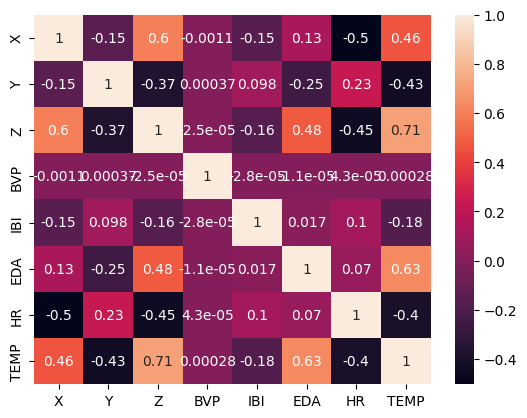

In [24]:
sns.heatmap(df.drop(columns = ['label', 'datetime']).corr(), annot = True)

<Axes: xlabel='label', ylabel='count'>

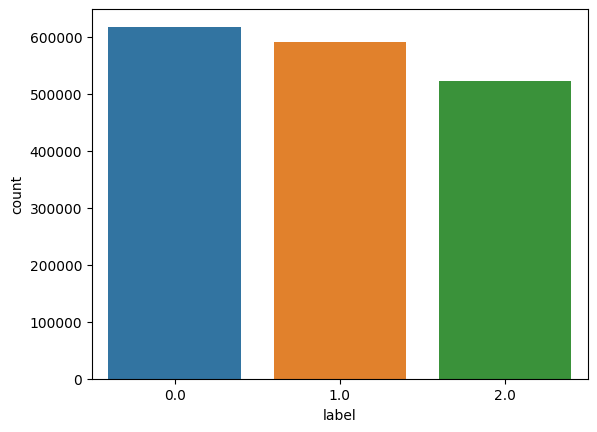

In [23]:
sns.countplot(data = df, x = 'label')

## 4. Visual Analytics

Scaling values of data for better readability

In [ ]:
scaled_df = df.copy()

scaled_df['datetime'] = pd.to_datetime(scaled_df['datetime'])
scaled_df['time'] = [x.time() for x in scaled_df['datetime']]
scaled_df['date'] = [x.date() for x in scaled_df['datetime']]
scaled_df = scaled_df.drop(columns = 'datetime')

col_names = scaled_df.columns[:-3]

scaled_df[col_names] = MinMaxScaler().fit_transform(scaled_df[col_names])

scaled_df.head()

,X,Y,Z,BVP,IBI,EDA,HR,TEMP,label,time,date
0,0.416,0.333,1.000,0.483,0.429,0.963,0.323,0.990,1.000,22:31:00,2020-04-14
1,0.416,0.333,1.000,0.494,0.429,0.963,0.323,0.990,1.000,22:31:00.031249,2020-04-14
2,0.416,0.333,1.000,0.502,0.429,0.963,0.323,0.990,1.000,22:31:00.062500,2020-04-14
3,0.416,0.333,1.000,0.506,0.429,0.963,0.323,0.990,1.000,22:31:00.093750,2020-04-14
4,0.416,0.333,1.000,0.506,0.429,0.963,0.323,0.990,1.000,22:31:00.124999,2020-04-14


Dates used for data visualization:
[datetime.date(2020, 6, 23) datetime.date(2020, 6, 24)
 datetime.date(2020, 6, 25)]


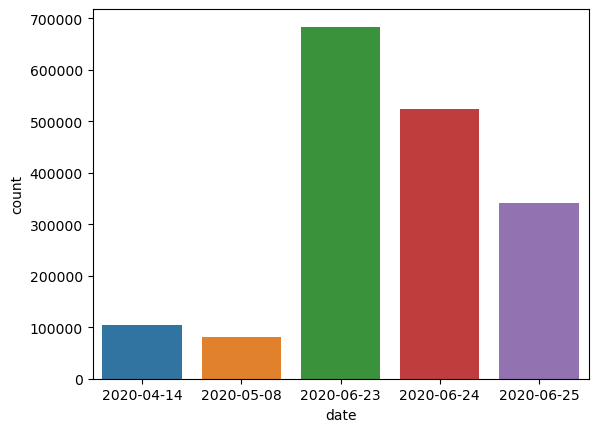

In [ ]:
sns.countplot(data = scaled_df, x = 'date')

dates = scaled_df['date'].unique()[2:]
print("Dates used for data visualization:")
print(dates)

Extracting rows containing the required dates for plotting data

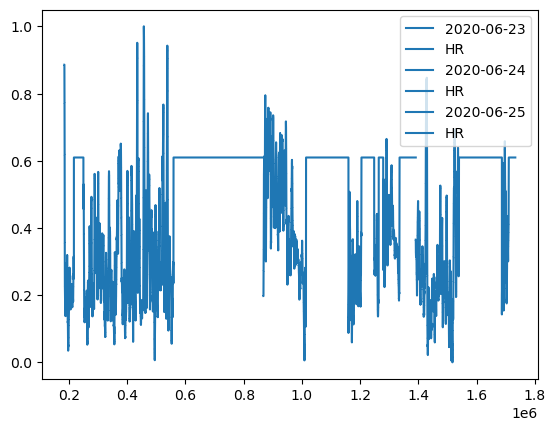

In [ ]:
temp = dict()
for date in dates:
    temp[str(date)] = scaled_df.loc[scaled_df['date'] == date, ['HR', 'time']]

for key in temp:
    sns.lineplot(data = temp[key], label = f'{key}')

## 5. Machine Learning Model

Function to split the data into train/test and converting it into a Keras sequence
Can be re-used to train the same model on all participants

In [3]:
def data_to_keras(df, scaled = True, lookback = 7):
    data = df.copy()
    data = data.drop(columns = 'id')
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.set_index('datetime')
    
    col_names = data.columns[: -1]
    if scaled:
        data[col_names] = MinMaxScaler().fit_transform(data[col_names])
    
    size = int(TRAIN_TEST_SPLIT * len(data))
    train = data[: size]
    test = data[size: ]
    
    train = TimeseriesGenerator(train.iloc[:, :-1], train.iloc[:, -1], length = lookback, batch_size = 32)
    test = TimeseriesGenerator(test.iloc[:, :-1], test.iloc[:, -1], length = lookback, batch_size = 32)
    
    return train, test

In [4]:
train, test = data_to_keras(df)

In [ ]:
# Define function to create LSTM model with given hyperparameters
def create_model(dropout_rate, units):
    model = Sequential()
    model.add(LSTM(units, input_shape=(7, 8)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# Create KerasRegressor wrapper function with create_model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define hyperparameters to search over
param_grid = {'dropout_rate': [0.1, 0.2, 0.3], 'units': [32, 64, 128]}

# Define randomized search over hyperparameters
search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=9, cv=5)

# Fit search on train generator and validate on test generator
search.fit(train, validation_data=test, epochs=10)

C:\Users\Diya\AppData\Local\Temp\ipykernel_11616\2361699427.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


ERROR! Session/line number was not unique in database. History logging moved to new session 19


In [ ]:
print(search.best_params_)
print(search.best_score_)

In [5]:
model = Sequential()
model.add(LSTM(64, input_shape=(7, 8)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
            loss = keras.losses.MeanSquaredError(),
            metrics=['mse'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________


In [1]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# train the model with early stopping
history = model.fit(train, epochs=20, validation_data=test, callbacks=[early_stopping])

NameError: ignored

In [ ]:
# plot the training and validation loss curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()